In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## !PIP THOI


In [ ]:
# !pip install ptflops

In [ ]:
# !pip install torch torchvision --upgrade

In [ ]:
# !pip install torch

In [ ]:
# !pip install bpemb

In [ ]:
!pip install torchviz


  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━

## Bpemb

In [ ]:
import numpy as np
from bpemb import BPEmb

""" Subword Embeddings: https://nlp.h-its.org/bpemb """

class Text2Embed:
    def __init__(self):
        self.bpemb_en = BPEmb(lang="en", vs=100000, dim=300)

    def to_tokens(self, word):
        tokens = self.bpemb_en.encode(word)
        return tokens

    def to_embed(self, word, mean=True):
        embed = self.bpemb_en.embed(word)
        if mean == True and len(embed) > 1:
            embed = np.mean(embed, axis=0)
            embed = np.expand_dims(embed, axis=0)
        return embed

if __name__ == "__main__":
    # words = ["polyp", "instrument", "nuclei", "skin cancer", "neural structure"]
    words = ["small", "medium", "large"]
    embed = Text2Embed()

    embed_vec = []
    for word in words:
        tokens = embed.to_tokens(word)
        vec = embed.to_embed(word, mean=False)
        embed_vec.append(vec)

        print(f"Tokens: {tokens} - Vec: {vec.shape}")

    embed_vec = np.array(embed_vec)
    print(embed_vec.shape)

## Res-Net 50

In [ ]:
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url
#from torchvision.models.utils import load_state_dict_from_url


__all__ = ['ResNet', 'resnet50']


model_urls = {
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
}


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

def resnet50(pretrained=True, progress=True, **kwargs):
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)

## Model

In [ ]:
from torchviz import make_dot
import torch.nn.functional as F

class conv2d(nn.Module):
    def __init__(self, in_c, out_c, kernel_size=3, padding=1, dilation=1, act=True):
        super().__init__()
        self.act = act

        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size, padding=padding, dilation=dilation, bias=False),
            nn.BatchNorm2d(out_c)
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        if self.act == True:
            x = self.relu(x)
        return x

class channel_attention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(channel_attention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc1   = nn.Conv2d(in_planes, in_planes // 16, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2   = nn.Conv2d(in_planes // 16, in_planes, 1, bias=False)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x0 = x
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return x0 * self.sigmoid(out)


class spatial_attention(nn.Module):
    def __init__(self, kernel_size=7):
        super(spatial_attention, self).__init__()

        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x0 = x
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return x0 * self.sigmoid(x)

class dilated_conv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)

        self.c1 = nn.Sequential(conv2d(in_c, out_c, kernel_size=1, padding=0), channel_attention(out_c))
        self.c2 = nn.Sequential(conv2d(in_c, out_c, kernel_size=(3, 3), padding=6, dilation=6), channel_attention(out_c))
        self.c3 = nn.Sequential(conv2d(in_c, out_c, kernel_size=(3, 3), padding=12, dilation=12), channel_attention(out_c))
        self.c4 = nn.Sequential(conv2d(in_c, out_c, kernel_size=(3, 3), padding=18, dilation=18), channel_attention(out_c))
        self.c5 = conv2d(out_c*4, out_c, kernel_size=3, padding=1, act=False)
        self.c6 = conv2d(in_c, out_c, kernel_size=1, padding=0, act=False)
        self.sa = spatial_attention()

    def forward(self, x):
        x1 = self.c1(x)
        x2 = self.c2(x)
        x3 = self.c3(x)
        x4 = self.c4(x)
        xc = torch.cat([x1, x2, x3, x4], axis=1)
        xc = self.c5(xc)
        xs = self.c6(x)
        x = self.relu(xc+xs)
        x = self.sa(x)
        return x

class label_attention(nn.Module):
    def __init__(self, in_c):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)

        """ Channel Attention """
        self.c1 = nn.Sequential(
            nn.Conv2d(in_c[1], in_c[0], kernel_size=1, padding=0, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_c[0], in_c[0], kernel_size=1, padding=0, bias=False)
        )

    def forward(self, feats, label):
        """ Channel Attention """
        b, c = label.shape
        label = label.reshape(b, c, 1, 1)
        ch_attn = self.c1(label)
        ch_map = torch.sigmoid(ch_attn)
        feats = feats * ch_map

        ch_attn = ch_attn.reshape(ch_attn.shape[0], ch_attn.shape[1])
        return ch_attn, feats

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c, scale=2):
        super().__init__()
        self.scale = scale
        self.relu = nn.ReLU(inplace=True)

        self.up = nn.Upsample(scale_factor=scale, mode="bilinear", align_corners=True)
        self.c1 = conv2d(in_c+out_c, out_c, kernel_size=1, padding=0)
        self.c2 = conv2d(out_c, out_c, act=False)
        self.c3 = conv2d(out_c, out_c, act=False)
        self.c4 = conv2d(out_c, out_c, kernel_size=1, padding=0, act=False)
        self.ca = channel_attention(out_c)
        self.sa = spatial_attention()

    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([x, skip], axis=1)
        x = self.c1(x)

        s1 = x
        x = self.c2(x)
        x = self.relu(x+s1)

        s2 = x
        x = self.c3(x)
        x = self.relu(x+s2+s1)

        s3 = x
        x = self.c4(x)
        x = self.relu(x+s3+s2+s1)

        x = self.ca(x)
        x = self.sa(x)
        return x

class output_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.c1 = nn.Conv2d(in_c, out_c, kernel_size=1, padding=0)

    def forward(self, x):
        x = self.up(x)
        x = self.c1(x)
        return x

class text_classifier(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Sequential(
            nn.Linear(in_c, in_c//8, bias=False), nn.ReLU(),
            nn.Linear(in_c//8, out_c[0], bias=False)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_c, in_c//8, bias=False), nn.ReLU(),
            nn.Linear(in_c//8, out_c[1], bias=False)
        )

    def forward(self, feats):
        pool = self.avg_pool(feats).view(feats.shape[0], feats.shape[1])
        num_polyps = self.fc1(pool)
        polyp_sizes = self.fc2(pool)
        return num_polyps, polyp_sizes

class embedding_feature_fusion(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.fc = nn.Sequential(
            nn.Conv2d((in_c[0]+in_c[1])*in_c[2], out_c, 1, bias=False), nn.ReLU(),
            nn.Conv2d(out_c, out_c, 1, bias=False), nn.ReLU()
        )

    def forward(self, num_polyps, polyp_sizes, label):
        num_polyps_prob = torch.softmax(num_polyps, axis=1)
        polyp_sizes_prob = torch.softmax(polyp_sizes, axis=1)
        prob = torch.cat([num_polyps_prob, polyp_sizes_prob], axis=1)
        prob = prob.view(prob.shape[0], prob.shape[1], 1)
        x = label * prob
        x = x.view(x.shape[0], -1, 1, 1)
        x = self.fc(x)
        x = x.view(x.shape[0], -1)
        return x

class multiscale_feature_aggregation(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)

        self.up_2x2 = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.up_4x4 = nn.Upsample(scale_factor=4, mode="bilinear", align_corners=True)

        self.c11 = conv2d(in_c[0], out_c, kernel_size=1, padding=0)
        self.c12 = conv2d(in_c[1], out_c, kernel_size=1, padding=0)
        self.c13 = conv2d(in_c[2], out_c, kernel_size=1, padding=0)
        self.c14 = conv2d(out_c*3, out_c, kernel_size=1, padding=0)

        self.c2 = conv2d(out_c, out_c, act=False)
        self.c3 = conv2d(out_c, out_c, act=False)

    def forward(self, x1, x2, x3):
        x1 = self.up_4x4(x1)
        x2 = self.up_2x2(x2)

        x1 = self.c11(x1)
        x2 = self.c12(x2)
        x3 = self.c13(x3)
        x = torch.cat([x1, x2, x3], axis=1)
        x = self.c14(x)

        s1 = x
        x = self.c2(x)
        x = self.relu(x+s1)

        s2 = x
        x = self.c3(x)
        x = self.relu(x+s2+s1)

        return x

class TGAPolypSeg(nn.Module):
    def __init__(self):
        super().__init__()

        """ Backbone: ResNet50 """
        backbone = resnet50()
        self.layer0 = nn.Sequential(backbone.conv1, backbone.bn1, backbone.relu)
        self.layer1 = nn.Sequential(backbone.maxpool, backbone.layer1)
        self.layer2 = backbone.layer2
        self.layer3 = backbone.layer3

        self.text_classifier = text_classifier(1024, [2, 3])
        self.label_fc = embedding_feature_fusion([2, 3, 300], 128)

        """ Dilated Conv """
        self.s1 = dilated_conv(64, 128)
        self.s2 = dilated_conv(256, 128)
        self.s3 = dilated_conv(512, 128)
        self.s4 = dilated_conv(1024, 128)

        """ Decoder """
        self.d1 = decoder_block(128, 128, scale=2)
        self.a1 = label_attention([128, 128])

        self.d2 = decoder_block(128, 128, scale=2)
        self.a2 = label_attention([128, 128])

        self.d3 = decoder_block(128, 128, scale=2)
        self.a3 = label_attention([128, 128])

        self.ag = multiscale_feature_aggregation([128, 128, 128], 128)

        self.y1 = output_block(128, 1)


    def forward(self, image, label):
        """ Backbone: ResNet50 """
        x0 = image
        x1 = self.layer0(x0)    ## [-1, 64, h/2, w/2]
        x2 = self.layer1(x1)    ## [-1, 256, h/4, w/4]
        x3 = self.layer2(x2)    ## [-1, 512, h/8, w/8]
        x4 = self.layer3(x3)    ## [-1, 1024, h/16, w/16]
        # print(x1.shape, x2.shape, x3.shape, x4.shape, x5.shape)

        num_polyps, polyp_sizes = self.text_classifier(x4)
        f0 = self.label_fc(num_polyps, polyp_sizes, label)

        """ Dilated Conv """
        s1 = self.s1(x1)
        s2 = self.s2(x2)
        s3 = self.s3(x3)
        s4 = self.s4(x4)
        # print(s1.shape, s2.shape, s3.shape, s4.shape)

        """ Decoder """
        d1 = self.d1(s4, s3)
        f1, a1 = self.a1(d1, f0)

        d2 = self.d2(a1, s2)
        f = f0 + f1
        f2, a2 = self.a2(d2, f)

        d3 = self.d3(a2, s1)
        f = f0 + f1 + f2
        f3, a3 = self.a3(d3, f)

        ag = self.ag(a1, a2, a3)
        y1 = self.y1(ag)

        return y1, num_polyps, polyp_sizes


def prepare_input(res):
    x1 = torch.FloatTensor(1, 3, 256, 256).cuda()
    x2 = torch.FloatTensor(1, 5, 300).cuda()
    return dict(x = [x1, x2])

if __name__ == "__main__":
    # x = torch.randn((4, 3, 256, 256))
    # l = torch.randn((4, 5, 300))
    # model = TGAPolypSeg()
    #
    # from ptflops import get_model_complexity_info
    # flops, params = get_model_complexity_info(model, input_res=(3, 256, 256), input_constructor=prepare_input, as_strings=True, print_per_layer_stat=False)
    # print('      - Flops:  ' + flops)
    # print('      - Params: ' + params)

    from ptflops import get_model_complexity_info

    model = TGAPolypSeg().cuda()
    flops, params = get_model_complexity_info(model, input_res=(512, 512),
                                              input_constructor=prepare_input,
                                              as_strings=True, print_per_layer_stat=False)
    print('      - Flops:  ', flops)
    print('      - Params: ', params)


    # from profile import profile
    # input_size = [(1, 3, 512, 512), (1, 1, 512, 512)]
    # # custom_ops = { '<your_layer_name' : '<your_custom_count_layer_function>', ... }
    # num_ops, num_params = profile(model, input_size)
    # print(num_ops, num_params)

Flops estimation was not finished successfully because of the following exception:
<class 'TypeError'> : TGAPolypSeg.forward() got an unexpected keyword argument 'x'
      - Flops:   None
      - Params:  None


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ptflops/pytorch_engine.py", line 62, in get_flops_pytorch
    _ = flops_model(**batch)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1532, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1582, in _call_impl
    result = forward_call(*args, **kwargs)
TypeError: TGAPolypSeg.forward() got an unexpected keyword argument 'x'


## Metric

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

""" Loss Functions -------------------------------------- """
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

class MultiClassBCE(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super().__init__()

    def forward(self, inputs, targets, smooth=1):
        loss = []
        for i in range(inputs.shape[1]):
            yp = inputs[:, i]
            yt = targets[:, i]
            BCE = F.binary_cross_entropy(yp, yt, reduction='mean')

            if i == 0:
                loss = BCE
            else:
                loss += BCE

        return loss


""" Metrics ------------------------------------------ """
def precision(y_true, y_pred):
    intersection = (y_true * y_pred).sum()
    return (intersection + 1e-15) / (y_pred.sum() + 1e-15)

def recall(y_true, y_pred):
    intersection = (y_true * y_pred).sum()
    return (intersection + 1e-15) / (y_true.sum() + 1e-15)

def F2(y_true, y_pred, beta=2):
    p = precision(y_true,y_pred)
    r = recall(y_true, y_pred)
    return (1+beta**2.) *(p*r) / float(beta**2*p + r + 1e-15)

def dice_score(y_true, y_pred):
    return (2 * (y_true * y_pred).sum() + 1e-15) / (y_true.sum() + y_pred.sum() + 1e-15)

def jac_score(y_true, y_pred):
    intersection = (y_true * y_pred).sum()
    union = y_true.sum() + y_pred.sum() - intersection
    return (intersection + 1e-15) / (union + 1e-15)

## Utils

In [ ]:
import os
import random
import numpy as np
import cv2
from tqdm import tqdm
import torch
from skimage.measure import label, regionprops, find_contours
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, confusion_matrix

""" Seeding the randomness. """
def seeding(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

""" Create a directory """
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

""" Shuffle the dataset. """
def shuffling(x, y, l):
    x, y, l = shuffle(x, y, l, random_state=42)
    return x, y, l

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def print_and_save(file_path, data_str):
    print(data_str)
    with open(file_path, "a") as file:
        file.write(data_str)
        file.write("\n")

def label_dictionary():
    label_dict = {}
    label_dict["polyp"] = ["one", "multiple", "small", "medium", "large"]
    return label_dict

""" Convert a mask to border image """
def mask_to_border(mask):
    h, w = mask.shape
    border = np.zeros((h, w))

    contours = find_contours(mask, 128)
    for contour in contours:
        for c in contour:
            x = int(c[0])
            y = int(c[1])
            border[x][y] = 255

    return border

""" Mask to bounding boxes """
def mask_to_bbox(mask):
    bboxes = []

    mask = mask_to_border(mask)
    lbl = label(mask)
    props = regionprops(lbl)
    for prop in props:
        x1 = prop.bbox[1]
        y1 = prop.bbox[0]

        x2 = prop.bbox[3]
        y2 = prop.bbox[2]

        bboxes.append([x1, y1, x2, y2])

    return bboxes

def calculate_metrics(y_true, y_pred):
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()

    y_pred = y_pred > 0.5
    y_pred = y_pred.reshape(-1)
    y_pred = y_pred.astype(np.uint8)

    y_true = y_true > 0.5
    y_true = y_true.reshape(-1)
    y_true = y_true.astype(np.uint8)

    ## Score
    score_jaccard = jac_score(y_true, y_pred)
    score_f1 = dice_score(y_true, y_pred)
    score_recall = recall(y_true, y_pred)
    score_precision = precision(y_true, y_pred)
    score_fbeta = F2(y_true, y_pred)
    score_acc = accuracy_score(y_true, y_pred)

    return [score_jaccard, score_f1, score_recall, score_precision, score_acc, score_fbeta]

## Train

In [ ]:
from keras.callbacks import ModelCheckpoint

In [ ]:
import os
import random
import time
import datetime
import numpy as np
import albumentations as A
import cv2
from glob import glob
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import tensorflow as tf
from sklearn.model_selection import train_test_split


def load_names(path, file_path):
    f = open(file_path, "r")
    data = f.read().split("\n")[:-1]
    images = [os.path.join(path,"images", name) + ".jpg" for name in data]
    masks = [os.path.join(path,"masks", name) + ".jpg" for name in data]
    return images, masks

def load_data(path, split=(0.7, 0.15, 0.15)):
    images = sorted(glob(os.path.join(path, "images/*")))
    masks = sorted(glob(os.path.join(path, "masks/*")))

    # Splitting images and masks into training and validation sets
    train_x, test_x, train_y, test_y = train_test_split(images, masks, test_size=split[2], random_state=42)
    train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=split[1]/(split[0]+split[1]), random_state=42)

    # Creating labels (assuming 'polyp' is a label category)
    train_label = [label_dictionary()["polyp"]] * len(train_x)
    valid_label = [label_dictionary()["polyp"]] * len(valid_x)
    test_label = [label_dictionary()["polyp"]] * len(test_x)
    return (train_x, train_y, train_label), (valid_x, valid_y, valid_label), (test_x, test_y, test_label)

class DATASET(Dataset):
    def __init__(self, images_path, labels_path, masks_path, size, transform=None):
        super().__init__()

        self.images_path = images_path
        self.labels_path = labels_path
        self.masks_path = masks_path
        self.transform = transform
        self.n_samples = len(images_path)

        self.embed = Text2Embed()

    def mask_to_text(self, mask):
        bboxes = mask_to_bbox(mask)
        num_polyps = 0 if len(bboxes) == 1 else 1

        polyp_sizes = None
        for bbox in bboxes:
            x1, y1, x2, y2 = bbox
            h = (y2 - y1)
            w = (x2 - x1)
            area = (h * w) / (mask.shape[0] * mask.shape[1])

            if area < 0.10:
                polyp_sizes = 0
            elif area >= 0.30:
                polyp_sizes = 2
            elif area >= 0.10 and area < 0.30:
                polyp_sizes = 1

        return np.array(num_polyps), np.array(polyp_sizes)

    def __getitem__(self, index):
        """ Reading Image & Mask """
        image = cv2.imread(self.images_path[index], cv2.IMREAD_COLOR)
        mask = cv2.imread(self.masks_path[index], cv2.IMREAD_GRAYSCALE)

        """ Applying Data Augmentation """
        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        """ Image """
        image = cv2.resize(image, size)
        image = np.transpose(image, (2, 0, 1))
        image = image/255.0

        """ Mask """
        mask = cv2.resize(mask, size)
        mask_copy = mask
        mask = np.expand_dims(mask, axis=0)
        mask = mask/255.0

        """ Mask to Textual information """
        num_polyps, polyp_sizes = self.mask_to_text(mask_copy)

        """ Label """
        label = []
        words = self.labels_path[index]
        for word in words:
            word_embed = self.embed.to_embed(word)[0]
            label.append(word_embed)
        label = np.array(label)

        return (image, label), (mask, num_polyps, polyp_sizes)

    def __len__(self):
        return self.n_samples

def train(model, loader, optimizer, loss_fn, device):
    model.train()

    epoch_loss = 0.0
    epoch_jac = 0.0
    epoch_f1 = 0.0
    epoch_recall = 0.0
    epoch_precision = 0.0

    for i, ((x, l), (y1, y2, y3)) in enumerate(loader):
        x = x.to(device, dtype=torch.float32)
        l = l.to(device, dtype=torch.float32)
        y1 = y1.to(device, dtype=torch.float32)
        y2 = y2.to(device, dtype=torch.long)
        y3 = y3.to(device, dtype=torch.long)

        optimizer.zero_grad()
        p1, p2, p3 = model(x, l)
        p2 = torch.softmax(p2, dim=1)
        p3 = torch.softmax(p3, dim=1)

        loss1 = loss_fn[0](p1, y1)
        loss2 = loss_fn[1](p2, y2)
        loss3 = loss_fn[2](p3, y3)
        loss = loss1 + loss2 + loss3
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        """ Calculate the metrics """
        batch_jac = []
        batch_f1 = []
        batch_recall = []
        batch_precision = []

        for yt, yp in zip(y1, p1):
            score = calculate_metrics(yt, yp)
            batch_jac.append(score[0])
            batch_f1.append(score[1])
            batch_recall.append(score[2])
            batch_precision.append(score[3])

        epoch_jac += np.mean(batch_jac)
        epoch_f1 += np.mean(batch_f1)
        epoch_recall += np.mean(batch_recall)
        epoch_precision += np.mean(batch_precision)

    epoch_loss = epoch_loss/len(loader)
    epoch_jac = epoch_jac/len(loader)
    epoch_f1 = epoch_f1/len(loader)
    epoch_recall = epoch_recall/len(loader)
    epoch_precision = epoch_precision/len(loader)

    return epoch_loss, [epoch_jac, epoch_f1, epoch_recall, epoch_precision]

def evaluate(model, loader, loss_fn, device):
    model.eval()

    epoch_loss = 0
    epoch_loss = 0.0
    epoch_jac = 0.0
    epoch_f1 = 0.0
    epoch_recall = 0.0
    epoch_precision = 0.0

    with torch.no_grad():
        for i, ((x, l), (y1, y2, y3)) in enumerate(loader):
            x = x.to(device, dtype=torch.float32)
            l = l.to(device, dtype=torch.float32)
            y1 = y1.to(device, dtype=torch.float32)
            y2 = y2.to(device, dtype=torch.long)
            y3 = y3.to(device, dtype=torch.long)

            p1, p2, p3 = model(x, l)
            p2 = torch.softmax(p2, dim=1)
            p3 = torch.softmax(p3, dim=1)

            loss1 = loss_fn[0](p1, y1)
            loss2 = loss_fn[1](p2, y2)
            loss3 = loss_fn[2](p3, y3)
            loss = loss1 + loss2 + loss3
            epoch_loss += loss.item()

            """ Calculate the metrics """
            batch_jac = []
            batch_f1 = []
            batch_recall = []
            batch_precision = []

            for yt, yp in zip(y1, p1):
                score = calculate_metrics(yt, yp)
                batch_jac.append(score[0])
                batch_f1.append(score[1])
                batch_recall.append(score[2])
                batch_precision.append(score[3])

            epoch_jac += np.mean(batch_jac)
            epoch_f1 += np.mean(batch_f1)
            epoch_recall += np.mean(batch_recall)
            epoch_precision += np.mean(batch_precision)

        epoch_loss = epoch_loss/len(loader)
        epoch_jac = epoch_jac/len(loader)
        epoch_f1 = epoch_f1/len(loader)
        epoch_recall = epoch_recall/len(loader)
        epoch_precision = epoch_precision/len(loader)

        return epoch_loss, [epoch_jac, epoch_f1, epoch_recall, epoch_precision]

if __name__ == "__main__":
    """ Seeding """
    seeding(42)

    """ Directories """
    create_dir("files")

    """ Training logfile """
    train_log_path = "files/train_log.txt"
    if os.path.exists(train_log_path):
        print("Log file exists")
    else:
        train_log = open("files/train_log.txt", "w")
        train_log.write("\n")
        train_log.close()

    """ Record Date & Time """
    datetime_object = str(datetime.datetime.now())
    print_and_save(train_log_path, datetime_object)
    print("")

    """ Hyperparameters """
    image_size = 256
    size = (image_size, image_size)
    batch_size = 16
    num_epochs = 20
    lr = 1e-4
    early_stopping_patience = 50
    checkpoint_path = "files/checkpoint.pth" #"/content/drive/MyDrive/D_Polyp/Polyp/Save_Result/save_Checkpoint"
    path = "/content/drive/MyDrive/D_Polyp/Polyp/Data/kvasir-seg/Kvasir-SEG"

    data_str = f"Image Size: {size}\nBatch Size: {batch_size}\nLR: {lr}\nEpochs: {num_epochs}\n"
    data_str += f"Early Stopping Patience: {early_stopping_patience}\n"
    print_and_save(train_log_path, data_str)

    """ Data augmentation: Transforms """
    transform =  A.Compose([
        A.Rotate(limit=35, p=0.3),
        A.HorizontalFlip(p=0.3),
        A.VerticalFlip(p=0.3),
        A.CoarseDropout(p=0.3, max_holes=10, max_height=32, max_width=32)
    ])

    """ Dataset """
    (train_x, train_y, train_label), (valid_x, valid_y, valid_label), (test_x, test_y, test_label) = load_data(path)

    data_str = f"Dataset Size:\nTrain: {len(train_x)} - Valid: {len(valid_x)}\n"
    print_and_save(train_log_path, data_str)

    """ Dataset and loader """
    train_dataset = DATASET(train_x, train_label, train_y, (image_size, image_size), transform=transform)
    valid_dataset = DATASET(valid_x, valid_label, valid_y, (image_size, image_size), transform=None)

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2
    )

    valid_loader = DataLoader(
        dataset=valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2
    )

    """ Model """
    device = torch.device('cuda')
    model = TGAPolypSeg()
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
    loss_fn = [DiceBCELoss(), nn.CrossEntropyLoss(), nn.CrossEntropyLoss()]
    loss_name = "BCE Dice Loss"
    data_str = f"Optimizer: Adam\nLoss: {loss_name}\n"
    print_and_save(train_log_path, data_str)

    """ Training the model """
    best_valid_metrics = 0.0
    early_stopping_count = 0

    def format_metrics(train_loss, train_metrics):
       return f"Train Loss: {train_loss:.4f} - Jaccard: {train_metrics[0]:.4f} - F1: {train_metrics[1]:.4f} - Recall: {train_metrics[2]:.4f} - Precision: {train_metrics[3]:.4f}"

    # Đường dẫn để lưu trữ model
    filepath = "/content/drive/MyDrive/Polyp/Save_Result/TGA"

    # Tạo callback ModelCheckpoint
    callback = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')

    # Huấn luyện mô hình
    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_metrics = train(model, train_loader, optimizer, loss_fn, device)
        valid_loss, valid_metrics = evaluate(model, valid_loader, loss_fn, device)
        scheduler.step(valid_loss)

        if valid_metrics[1] > best_valid_metrics:
            print_and_save(train_log_path, f"Valid F1 improved from {best_valid_metrics:2.4f} to {valid_metrics[1]:2.4f}. Saving checkpoint: {checkpoint_path}")

            best_valid_metrics = valid_metrics[1]
            torch.save(model.state_dict(), checkpoint_path)
            early_stopping_count = 0

        elif valid_metrics[1] < best_valid_metrics:
            early_stopping_count += 1

        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        metrics_str = format_metrics(train_loss, train_metrics)
        print_and_save(train_log_path, f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s\n{metrics_str}\n")
        print_and_save(train_log_path, f"\tVal. Loss: {valid_loss:.4f} - Jaccard: {valid_metrics[0]:.4f} - F1: {valid_metrics[1]:.4f} - Recall: {valid_metrics[2]:.4f} - Precision: {valid_metrics[3]:.4f}\n")

        if early_stopping_count == early_stopping_patience:
            print_and_save(train_log_path, f"Early stopping: validation loss stops improving from last {early_stopping_patience} continously.\n")
            break



Log file exists
2024-06-25 09:42:26.883855

Image Size: (256, 256)
Batch Size: 16
LR: 0.0001
Epochs: 20
Early Stopping Patience: 50

Dataset Size:
Train: 700 - Valid: 150

Optimizer: Adam
Loss: BCE Dice Loss



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Valid F1 improved from 0.0000 to 0.4070. Saving checkpoint: files/checkpoint.pth
Epoch: 01 | Epoch Time: 6m 19s
Train Loss: 2.3605 - Jaccard: 0.5834 - F1: 0.6970 - Recall: 0.7369 - Precision: 0.7518

	Val. Loss: 2.4157 - Jaccard: 0.2942 - F1: 0.4070 - Recall: 0.2961 - Precision: 0.9869



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Valid F1 improved from 0.4070 to 0.8091. Saving checkpoint: files/checkpoint.pth
Epoch: 02 | Epoch Time: 1m 27s
Train Loss: 1.9856 - Jaccard: 0.7274 - F1: 0.8231 - Recall: 0.8257 - Precision: 0.8741

	Val. Loss: 1.9319 - Jaccard: 0.7102 - F1: 0.8091 - Recall: 0.7844 - Precision: 0.9004



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Valid F1 improved from 0.8091 to 0.8431. Saving checkpoint: files/checkpoint.pth
Epoch: 03 | Epoch Time: 1m 28s
Train Loss: 1.8579 - Jaccard: 0.7636 - F1: 0.8494 - Recall: 0.8510 - Precision: 0.8892

	Val. Loss: 1.8598 - Jaccard: 0.7532 - F1: 0.8431 - Recall: 0.8477 - Precision: 0.8855



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Valid F1 improved from 0.8431 to 0.8583. Saving checkpoint: files/checkpoint.pth
Epoch: 04 | Epoch Time: 1m 29s
Train Loss: 1.8027 - Jaccard: 0.7939 - F1: 0.8724 - Recall: 0.8706 - Precision: 0.9073

	Val. Loss: 1.8308 - Jaccard: 0.7791 - F1: 0.8583 - Recall: 0.8675 - Precision: 0.8892



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 05 | Epoch Time: 1m 27s
Train Loss: 1.7853 - Jaccard: 0.8011 - F1: 0.8755 - Recall: 0.8660 - Precision: 0.9206

	Val. Loss: 1.8236 - Jaccard: 0.7736 - F1: 0.8555 - Recall: 0.8513 - Precision: 0.9088



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 06 | Epoch Time: 1m 26s
Train Loss: 1.7457 - Jaccard: 0.8112 - F1: 0.8841 - Recall: 0.8811 - Precision: 0.9160

	Val. Loss: 1.8372 - Jaccard: 0.7612 - F1: 0.8420 - Recall: 0.8027 - Precision: 0.9372



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Valid F1 improved from 0.8583 to 0.8622. Saving checkpoint: files/checkpoint.pth
Epoch: 07 | Epoch Time: 1m 26s
Train Loss: 1.7065 - Jaccard: 0.8336 - F1: 0.8989 - Recall: 0.8981 - Precision: 0.9197

	Val. Loss: 1.7870 - Jaccard: 0.7860 - F1: 0.8622 - Recall: 0.8620 - Precision: 0.9113



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Valid F1 improved from 0.8622 to 0.8673. Saving checkpoint: files/checkpoint.pth
Epoch: 08 | Epoch Time: 1m 27s
Train Loss: 1.6942 - Jaccard: 0.8438 - F1: 0.9064 - Recall: 0.8983 - Precision: 0.9339

	Val. Loss: 1.7852 - Jaccard: 0.7907 - F1: 0.8673 - Recall: 0.8658 - Precision: 0.9143



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 09 | Epoch Time: 1m 26s
Train Loss: 1.6969 - Jaccard: 0.8436 - F1: 0.9051 - Recall: 0.8936 - Precision: 0.9392

	Val. Loss: 1.7987 - Jaccard: 0.7851 - F1: 0.8583 - Recall: 0.8392 - Precision: 0.9226



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 10 | Epoch Time: 1m 27s
Train Loss: 1.6640 - Jaccard: 0.8561 - F1: 0.9152 - Recall: 0.9109 - Precision: 0.9367

	Val. Loss: 1.8489 - Jaccard: 0.7705 - F1: 0.8475 - Recall: 0.8724 - Precision: 0.8859



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 11 | Epoch Time: 1m 28s
Train Loss: 1.6469 - Jaccard: 0.8610 - F1: 0.9175 - Recall: 0.9105 - Precision: 0.9432

	Val. Loss: 1.7696 - Jaccard: 0.7909 - F1: 0.8636 - Recall: 0.8946 - Precision: 0.8805



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 12 | Epoch Time: 1m 28s
Train Loss: 1.6016 - Jaccard: 0.8719 - F1: 0.9249 - Recall: 0.9182 - Precision: 0.9473

	Val. Loss: 1.7507 - Jaccard: 0.7718 - F1: 0.8503 - Recall: 0.8179 - Precision: 0.9411



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Valid F1 improved from 0.8673 to 0.8715. Saving checkpoint: files/checkpoint.pth
Epoch: 13 | Epoch Time: 1m 29s
Train Loss: 1.5759 - Jaccard: 0.8691 - F1: 0.9237 - Recall: 0.9175 - Precision: 0.9422

	Val. Loss: 1.7349 - Jaccard: 0.7970 - F1: 0.8715 - Recall: 0.8973 - Precision: 0.8890



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Valid F1 improved from 0.8715 to 0.8724. Saving checkpoint: files/checkpoint.pth
Epoch: 14 | Epoch Time: 1m 27s
Train Loss: 1.5575 - Jaccard: 0.8676 - F1: 0.9225 - Recall: 0.9143 - Precision: 0.9464

	Val. Loss: 1.6917 - Jaccard: 0.7991 - F1: 0.8724 - Recall: 0.8769 - Precision: 0.9120



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 15 | Epoch Time: 1m 26s
Train Loss: 1.5318 - Jaccard: 0.8721 - F1: 0.9254 - Recall: 0.9215 - Precision: 0.9421

	Val. Loss: 1.7304 - Jaccard: 0.7904 - F1: 0.8651 - Recall: 0.8617 - Precision: 0.9128



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 16 | Epoch Time: 1m 27s
Train Loss: 1.4778 - Jaccard: 0.8743 - F1: 0.9273 - Recall: 0.9220 - Precision: 0.9450

	Val. Loss: 1.7221 - Jaccard: 0.7989 - F1: 0.8651 - Recall: 0.8714 - Precision: 0.9061



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 17 | Epoch Time: 1m 27s
Train Loss: 1.4541 - Jaccard: 0.8695 - F1: 0.9254 - Recall: 0.9204 - Precision: 0.9412

	Val. Loss: 1.7322 - Jaccard: 0.7755 - F1: 0.8520 - Recall: 0.8193 - Precision: 0.9454



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 18 | Epoch Time: 1m 27s
Train Loss: 1.4549 - Jaccard: 0.8724 - F1: 0.9253 - Recall: 0.9229 - Precision: 0.9422

	Val. Loss: 1.6619 - Jaccard: 0.7922 - F1: 0.8591 - Recall: 0.8732 - Precision: 0.9017



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 19 | Epoch Time: 1m 26s
Train Loss: 1.4235 - Jaccard: 0.8805 - F1: 0.9307 - Recall: 0.9252 - Precision: 0.9502

	Val. Loss: 1.6282 - Jaccard: 0.7973 - F1: 0.8714 - Recall: 0.8831 - Precision: 0.8952



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 20 | Epoch Time: 1m 26s
Train Loss: 1.4276 - Jaccard: 0.8692 - F1: 0.9216 - Recall: 0.9192 - Precision: 0.9394

	Val. Loss: 1.6398 - Jaccard: 0.7955 - F1: 0.8681 - Recall: 0.8867 - Precision: 0.9001



#Test


In [ ]:
import cv2
import torch
import numpy as np
import os
import time
from tqdm import tqdm
from operator import add
import matplotlib.pyplot as plt

def process_mask(y_pred):
    y_pred = y_pred[0].cpu().numpy()
    y_pred = np.squeeze(y_pred, axis=0)
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.int32)
    y_pred = y_pred * 255
    y_pred = np.array(y_pred, dtype=np.uint8)
    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=2)
    return y_pred

def print_score(metrics_score):
    jaccard = metrics_score[0]/len(test_x)
    f1 = metrics_score[1]/len(test_x)
    recall = metrics_score[2]/len(test_x)
    precision = metrics_score[3]/len(test_x)
    acc = metrics_score[4]/len(test_x)
    f2 = metrics_score[5]/len(test_x)

    print(f"Jaccard: {jaccard:1.4f} - F1: {f1:1.4f} - Recall: {recall:1.4f} - Precision: {precision:1.4f} - Acc: {acc:1.4f} - F2: {f2:1.4f}")

def evaluate(model, save_path, test_x, test_y, test_l, size, embed):
    metrics_score_1 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    time_taken = []

    for i, (x, l, y) in tqdm(enumerate(zip(test_x, test_l, test_y)), total=len(test_x)):
        # Kiểm tra nếu y là danh sách
        if isinstance(y, list):
            # Nếu y là danh sách, lấy phần tử đầu tiên
            y = y[0]

    for i, (x, l, y) in tqdm(enumerate(zip(test_x, test_l, test_y)), total=len(test_x)):
        name = y.split("/")[-1].split(".")[0]

        """ Image """
        image = cv2.imread(x, cv2.IMREAD_COLOR)
        image = cv2.resize(image, size)
        save_img = image
        image = np.transpose(image, (2, 0, 1))
        image = image/255.0
        image = np.expand_dims(image, axis=0)
        image = image.astype(np.float32)
        image = torch.from_numpy(image)
        image = image.to(device)

        """ Label """
        label = []
        for word in l:
            word_embed = embed.to_embed(word)[0]
            label.append(word_embed)
        label = np.array(label)
        label = np.expand_dims(label, axis=0)
        label = torch.from_numpy(label)
        label = label.to(device)

        """ Mask """
        mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, size)
        save_mask = mask
        save_mask = np.expand_dims(save_mask, axis=-1)
        save_mask = np.concatenate([save_mask, save_mask, save_mask], axis=2)
        mask = np.expand_dims(mask, axis=0)
        mask = mask/255.0
        mask = np.expand_dims(mask, axis=0)
        mask = mask.astype(np.float32)
        mask = torch.from_numpy(mask)
        mask = mask.to(device)

        with torch.no_grad():
            """ FPS calculation """
            start_time = time.time()
            p1, p2, p3 = model(image, label)

            p1 = torch.sigmoid(p1)
            p2 = torch.softmax(p2, axis=1).cpu().numpy()[0]
            p3 = torch.softmax(p3, axis=1).cpu().numpy()[0]

            end_time = time.time() - start_time
            time_taken.append(end_time)

            """ Evaluation metrics """
            score_1 = calculate_metrics(mask, p1)
            metrics_score_1 = list(map(add, metrics_score_1, score_1))
            p1 = process_mask(p1)

        """ Save the image - mask - pred """
        line = np.ones((size[0], 10, 3)) * 255
        cat_images = np.concatenate([save_img, line, save_mask, line, p1], axis=1)

        save_image_name = f"{name}"
        # p2 = np.argmax(p2)
        # p3 = np.argmax(p3)
        #
        # if p2 == 0:
        #     save_image_name += "-one_polyp"
        # else:
        #     save_image_name += "-multiple_polyp"
        #
        # if p3 == 0: save_image_name += "-small"
        # if p3 == 1: save_image_name += "-medium"
        # if p3 == 2: save_image_name += "-large"

        cv2.imwrite(f"{save_path}/all/{name}.jpg", cat_images)
        cv2.imwrite(f"{save_path}/mask/{name}.jpg", p1)

    print_score(metrics_score_1)

    mean_time_taken = np.mean(time_taken)
    mean_fps = 1/mean_time_taken
    print("Mean FPS: ", mean_fps)

if __name__ == "__main__":
    """ Seeding """
    seeding(42)

    """ Load the checkpoint """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = TGAPolypSeg()
    model = model.to(device)
    checkpoint_path = "files/checkpoint.pth"
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.eval()

    """ Test dataset """
    path = "/content/drive/MyDrive/D_Polyp/Polyp/Data/kvasir-seg/Kvasir-SEG"
    (train_x, train_y, train_label), (valid_x, valid_y, valid_label), (test_x, test_y, test_label) = load_data(path)

    embed = Text2Embed()
    save_path = f"/content/drive/MyDrive/D_Polyp/Polyp/Save_Result/TGA"
    size = (256, 256)
    create_dir(f"{save_path}/all")
    create_dir(f"{save_path}/mask")
    evaluate(model, save_path, test_x, test_y, test_label, size, embed)


100%|██████████| 150/150 [05:46<00:00,  2.31s/it]

Jaccard: 0.7949 - F1: 0.8643 - Recall: 0.8950 - Precision: 0.8819 - Acc: 0.9603 - F2: 0.8732
Mean FPS:  18.147866789370546


# Visualize

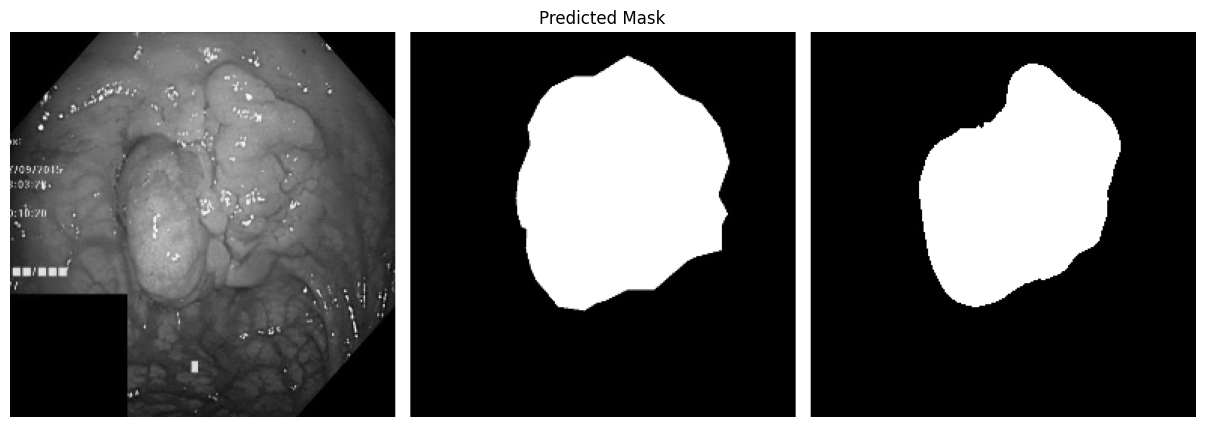

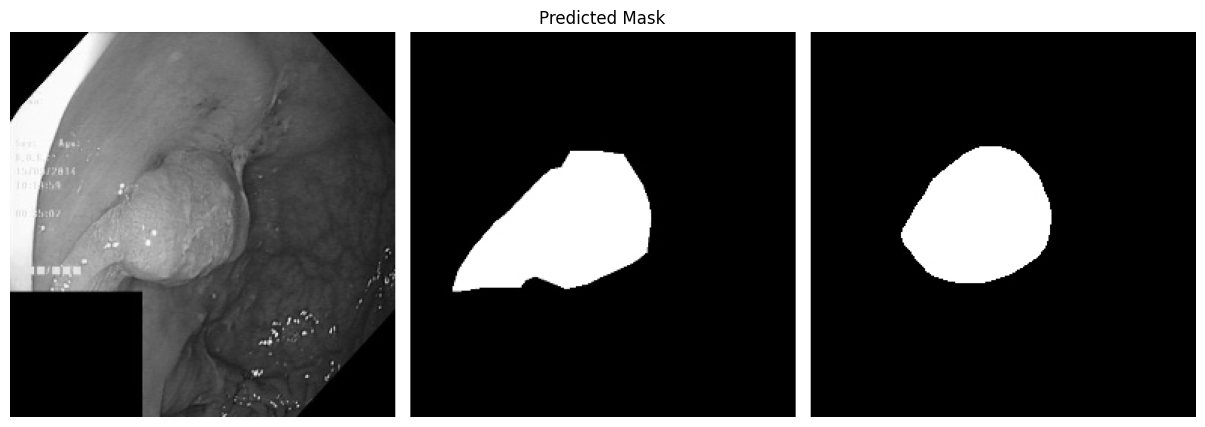

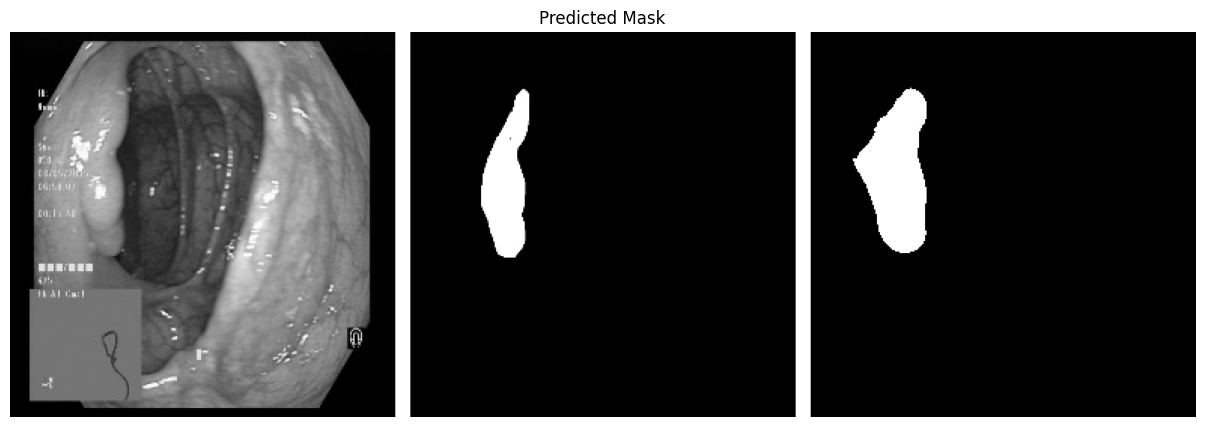

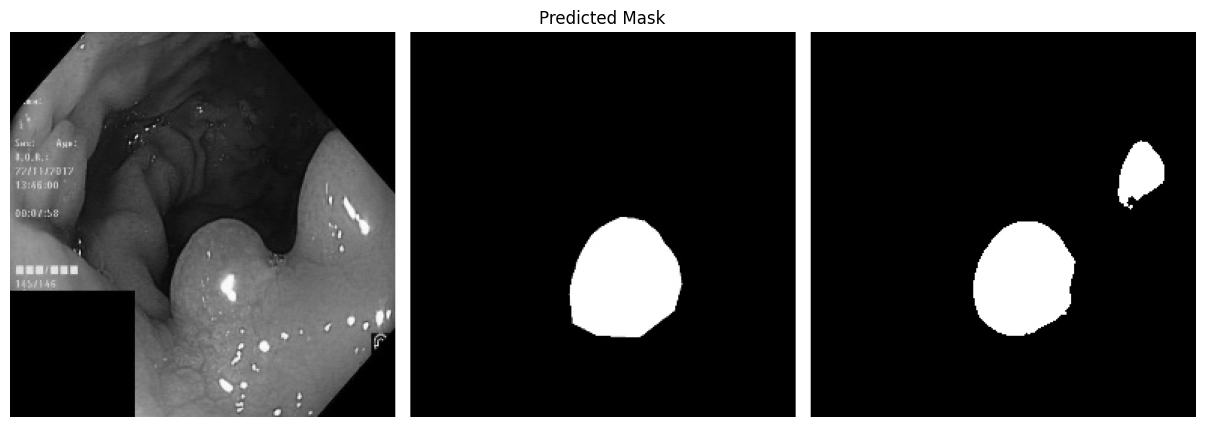

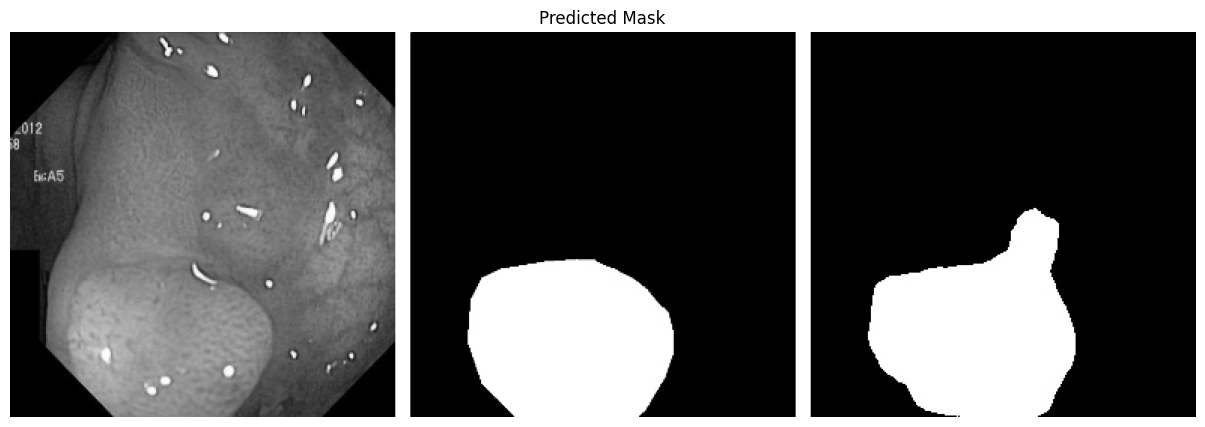

In [ ]:
import cv2
import os
import random
import matplotlib.pyplot as plt

def visualize_results(predicted_mask): #original_image, true_mask, predicted_mask):
    """ Hiển thị hình ảnh gốc, mặt nạ thực tế và mặt nạ dự đoán """
    plt.figure(figsize=(30, 5))

    # plt.subplot(1, 3, 1)
    # plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    # plt.title('Original Image')
    # plt.axis('off')

    # plt.subplot(1, 3, 2)
    # plt.imshow(true_mask, cmap='gray')
    # plt.title('True Mask')
    # plt.axis('off')

    # plt.subplot(1, 3, 2)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.show()

# Đường dẫn thư mục chứa kết quả
result_dir = "/content/drive/MyDrive/D_Polyp/Polyp/Save_Result/TGA"

# Lấy danh sách tên các tập tin hình ảnh
image_files = os.listdir(result_dir + "/all")[:5]

# Lặp qua từng tập tin hình ảnh ngẫu nhiên
for filename in image_files:
    if filename.endswith(".jpg"):
        # Đường dẫn đến hình ảnh gốc
        #original_image_path = os.path.join(result_dir + "/all", filename)

        # Tạo tên tương ứng cho các hình ảnh mặt nạ thực tế và dự đoán
        # mask_filename = filename.split(".")[0] + ".jpg"
        # true_mask_path = os.path.join(result_dir + "/mask", mask_filename)
        predicted_mask_path = os.path.join(result_dir + "/all", filename)

        # Đọc hình ảnh gốc, mặt nạ thực tế và mặt nạ dự đoán
        #original_image = cv2.imread(original_image_path)
        # true_mask = cv2.imread(true_mask_path, cv2.IMREAD_GRAYSCALE)
        predicted_mask = cv2.imread(predicted_mask_path, cv2.IMREAD_GRAYSCALE)

        # Gọi hàm để hiển thị hình ảnh kết quả
        visualize_results(predicted_mask)
